In [1]:
!pip install obspy

In [2]:
import pandas as pd
import numpy as np
import json
import glob
import obspy
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees
import os
import h5py
import gc
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


gl_df: 지진 목록 데이터

gw_df: 지하수 데이터

gs_df: 지진파 데이터

label: 정답 label

# 지진 목록 데이터

## 데이터 불러오기

In [4]:
gl = pd.read_html('/content/drive/MyDrive/TriAI/Data/포항_2017/포항_지진목록_2017년.xls')[0]

gl.columns = [
    '번호',
    '발생시각',
    '규모',
    '깊이(km)',
    '최대 진도',
    '위도',
    '경도',
    '위치',
    '지도보기',
    '상세정보(진도 등)'
]

In [5]:
gl = gl[['발생시각', '규모', '깊이(km)', '위도', '경도']]

## 데이터 확인

In [6]:
gl.head()

,발생시각,규모,깊이(km),위도,경도
0,2017/12/30 10:35:17,1.0,11,36.11 N,129.34 E
1,2017/12/30 01:00:12,1.4,10,36.09 N,129.35 E
2,2017/12/30 00:53:44,1.5,10,36.09 N,129.35 E
3,2017/12/30 00:05:19,1.3,10,36.09 N,129.34 E
4,2017/12/29 21:33:24,1.6,8,36.12 N,129.39 E


In [7]:
gl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   발생시각    524 non-null    object 
 1   규모      524 non-null    float64
 2   깊이(km)  524 non-null    object 
 3   위도      524 non-null    object 
 4   경도      524 non-null    object 
dtypes: float64(1), object(4)
memory usage: 20.6+ KB


## 데이터 전처리

### 형변환

In [8]:
# 숫자가 아닌 문자가 섞인 경우 강제 변환
columns_to_numeric = ['깊이(km)', '위도', '경도']

for col in columns_to_numeric:
  gl[col] = pd.to_numeric(gl[col].astype(str).str.replace(r'[a-zA-Z가-힣]', '', regex=True), errors='coerce')

gl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   발생시각    524 non-null    object 
 1   규모      524 non-null    float64
 2   깊이(km)  476 non-null    float64
 3   위도      524 non-null    float64
 4   경도      524 non-null    float64
dtypes: float64(4), object(1)
memory usage: 20.6+ KB


In [9]:
gl.head()

,발생시각,규모,깊이(km),위도,경도
0,2017/12/30 10:35:17,1.0,11.0,36.11,129.34
1,2017/12/30 01:00:12,1.4,10.0,36.09,129.35
2,2017/12/30 00:53:44,1.5,10.0,36.09,129.35
3,2017/12/30 00:05:19,1.3,10.0,36.09,129.34
4,2017/12/29 21:33:24,1.6,8.0,36.12,129.39


### 발생시각 -> 발생날짜로 변경
하루 중 가장 큰 규모의 지진을 대표값으로 설정해 남김

In [10]:
gl['발생시각'] = pd.to_datetime(gl['발생시각'], errors='coerce')
gl['발생일'] = gl['발생시각'].dt.normalize()
gl_sorted = gl.sort_values(by=['발생일', '규모'], ascending=[True, False])

gl_df = gl_sorted.drop_duplicates(subset=['발생일'], keep='first')

target_cols = ['발생일', '규모', '깊이(km)', '위도', '경도']
gl_df = gl_df[target_cols]

gl_df = gl_df.sort_values('발생일').reset_index(drop=True)

In [11]:
gl_df.head()

,발생일,규모,깊이(km),위도,경도
0,2017-03-09,2.0,22.0,35.82,129.78
1,2017-03-19,1.9,19.0,35.88,129.71
2,2017-04-15,3.1,13.0,36.11,129.36
3,2017-06-25,1.0,19.0,35.98,129.61
4,2017-09-11,1.9,5.0,36.10,129.35


In [12]:
gl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   발생일     48 non-null     datetime64[ns]
 1   규모      48 non-null     float64       
 2   깊이(km)  43 non-null     float64       
 3   위도      48 non-null     float64       
 4   경도      48 non-null     float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 2.0 KB


In [13]:
gl_df.describe()

,발생일,규모,깊이(km),위도,경도
count,48,48.000000,43.000000,48.000000,48.000000
mean,2017-11-07 05:00:00,2.002083,10.302326,36.079167,129.394583
min,2017-03-09 00:00:00,1.000000,5.000000,35.810000,129.320000
25%,2017-11-16 18:00:00,1.475000,8.000000,36.087500,129.350000
50%,2017-11-28 12:00:00,1.800000,9.000000,36.105000,129.360000
75%,2017-12-14 06:00:00,2.300000,12.000000,36.112500,129.370000
max,2017-12-30 00:00:00,5.400000,22.000000,36.140000,129.780000
std,NaN,0.854149,4.177803,0.078356,0.110241


### 결측치 처리

In [14]:
gl_df['깊이(km)'] = gl_df['깊이(km)'].fillna(gl_df['깊이(km)'].median())
gl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   발생일     48 non-null     datetime64[ns]
 1   규모      48 non-null     float64       
 2   깊이(km)  48 non-null     float64       
 3   위도      48 non-null     float64       
 4   경도      48 non-null     float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 2.0 KB


## label 데이터 생성

In [15]:
# 발생일, 규모로 label 생성
gl_label = gl_df.copy()
gl_label = gl_df[['발생일', '규모']]
gl_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   발생일     48 non-null     datetime64[ns]
 1   규모      48 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 900.0 bytes


In [16]:
gl_label

,발생일,규모
0,2017-03-09,2.0
1,2017-03-19,1.9
2,2017-04-15,3.1
3,2017-06-25,1.0
4,2017-09-11,1.9
5,2017-09-16,1.6
6,2017-09-22,1.3
7,2017-09-23,1.1
8,2017-09-29,1.8
9,2017-10-03,1.2


In [17]:
# 지진이 발생하지 않은 날도 label로 생성(규모 0으로 설정)
gl_label = gl_label.set_index('발생일')
full_date = pd.date_range(start='2017-01-01', end='2017-12-31', freq='D')
label = gl_label.reindex(full_date, fill_value=0)
label.index.name = '발생일'
label.reset_index()
label

,규모
발생일,
2017-01-01,0.0
2017-01-02,0.0
2017-01-03,0.0
2017-01-04,0.0
2017-01-05,0.0
...,...
2017-12-27,2.8
2017-12-28,1.2
2017-12-29,2.1


# 지하수 데이터

## 데이터 불러오기

In [18]:
gw1 = pd.read_json('/content/drive/MyDrive/TriAI/Data/포항_2017/지하수 데이터/gims_data_7850.json')
gw2 = pd.read_json('/content/drive/MyDrive/TriAI/Data/포항_2017/지하수 데이터/gims_data_9888.json')
gw3 = pd.read_json('/content/drive/MyDrive/TriAI/Data/포항_2017/지하수 데이터/gims_data_9889.json')
gw4 = pd.read_json('/content/drive/MyDrive/TriAI/Data/포항_2017/지하수 데이터/gims_data_73541.json')
gw5 = pd.read_json('/content/drive/MyDrive/TriAI/Data/포항_2017/지하수 데이터/gims_data_73543.json')
gw6 = pd.read_json('/content/drive/MyDrive/TriAI/Data/포항_2017/지하수 데이터/gims_data_622083.json')

## 6개 데이터 합치기 -> DataFrame 생성

In [19]:
gw_list = [gw1, gw2, gw3, gw4, gw5, gw6]
all_rows = []

for df in gw_list:
  if 'response' in df.columns:
    content = df['response']['resultData']

    if isinstance(content, list):
      all_rows.extend(content)
    else:
      all_rows.extend(df.loc['resultData', 'response'])

gw = pd.DataFrame(all_rows)
gw.head()

,gennum,elev,wtemp,lev,ec,ymd
0,7850,-3.4,15.996,9.29,978.167,20170101
1,7850,-3.277,15.996,9.17,977.375,20170102
2,7850,-3.32,16,9.21,976.917,20170103
3,7850,-3.415,15.996,9.31,976.083,20170104
4,7850,-3.526,16,9.42,975.708,20170105


## 데이터 확인

**<column 별 의미>**

gennum: 관측소번호

ymd: 관측날짜

elev: 수위

wtemp: 수온

lev(표고-수위): 심도

ec: EC

In [20]:
gw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   gennum  2190 non-null   object
 1   elev    2190 non-null   object
 2   wtemp   2190 non-null   object
 3   lev     2190 non-null   object
 4   ec      2190 non-null   object
 5   ymd     2190 non-null   object
dtypes: object(6)
memory usage: 102.8+ KB


In [21]:
# 관측소별 데이터 확인
gw['gennum'].value_counts()

,count
gennum,
7850,365
9888,365
9889,365
73541,365
73543,365
622083,365


## 데이터 전처리

### 형변환

In [22]:
# 1. 수치형 데이터 변환
numeric_columns = ['elev', 'wtemp', 'lev', 'ec']

for col in numeric_columns:
  gw[col] = pd.to_numeric(gw[col], errors='coerce')

# 2. 날짜형 데이터 변환
gw['ymd'] = pd.to_datetime(gw['ymd'], format='%Y%m%d')

# 3. 날짜를 인덱스로 설정 및 정렬
gw = gw.set_index('ymd').sort_index()

In [23]:
gw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2190 entries, 2017-01-01 to 2017-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gennum  2190 non-null   object 
 1   elev    2190 non-null   float64
 2   wtemp   2190 non-null   float64
 3   lev     2190 non-null   float64
 4   ec      2190 non-null   float64
dtypes: float64(4), object(1)
memory usage: 102.7+ KB


In [24]:
gw.head()

,gennum,elev,wtemp,lev,ec
ymd,,,,,
2017-01-01,7850,-3.400,15.996,9.29,978.167
2017-01-01,73541,30.249,14.100,11.35,226.625
2017-01-01,9888,26.580,15.300,2.15,616.333
2017-01-01,73543,117.642,14.408,3.48,136.042
2017-01-01,622083,76.645,14.994,9.17,968.583


In [25]:
gw.describe()

,elev,wtemp,lev,ec
count,2190.000000,2190.000000,2190.000000,2190.000000
mean,53.799544,14.962973,7.123607,597.350969
std,39.471191,0.914816,3.543213,341.475307
min,-4.536000,11.675000,1.920000,105.125000
25%,26.482750,14.292000,4.242500,300.958000
50%,54.524000,15.200000,6.690000,489.583500
75%,76.053750,15.499000,9.840000,968.000000
max,118.304000,16.052000,15.280000,1048.083000


### MinMaxScaler로 스케일링

In [26]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(gw)
gw_scaled = pd.DataFrame(scaled_data, columns=gw.columns)

### GRU 입력을 위한 3차원 변환

In [27]:
# 관측소(gennum)별로 컬럼 펼치기
gw_pivot = gw.pivot_table(index='ymd', columns='gennum', values=['elev', 'wtemp', 'lev', 'ec'])

# 컬럼 이름 깔끔하게 정리
gw_pivot.columns = [f"{col[0]}_{col[1]}" for col in gw_pivot.columns]

print(gw_pivot.head())

            ec_622083  ec_73541  ec_73543  ec_7850  ec_9888  ec_9889  \
ymd                                                                    
2017-01-01    968.583   226.625   136.042  978.167  616.333  300.458   
2017-01-02    968.917   229.042   134.167  977.375  616.708  300.542   
2017-01-03    969.417   229.083   131.750  976.917  616.292  300.500   
2017-01-04    969.208   229.125   128.667  976.083  617.042  300.375   
2017-01-05    969.500   233.250   126.083  975.708  618.458  300.500   

            elev_622083  elev_73541  elev_73543  elev_7850  ...  lev_73543  \
ymd                                                         ...              
2017-01-01       76.645      30.249     117.642     -3.400  ...       3.48   
2017-01-02       76.659      30.157     117.587     -3.277  ...       3.54   
2017-01-03       76.650      30.039     117.462     -3.320  ...       3.66   
2017-01-04       76.638      29.942     117.383     -3.415  ...       3.74   
2017-01-05       76.615    

In [28]:
# 선형 보간
gw_pivot = gw_pivot.interpolate(method='linear', limit_direction='both')

# 선형 보간 이후도 비어있으면 평균값 등으로 채움
gw_pivot = gw_pivot.fillna(method='bfill').fillna(method='ffill')

/tmp/ipython-input-4111882620.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gw_pivot = gw_pivot.fillna(method='bfill').fillna(method='ffill')


In [29]:
def create_sequences(data, label, window_size=3):
    X, y = [], []
    # 데이터 길이 - 윈도우 크기 만큼 반복
    for i in range(len(data) - window_size):
        # 입력(X): i일부터 i+window_size-1일까지의 지하수 데이터
        X.append(data.iloc[i:i+window_size].values)
        # 정답(y): i+window_size일의 지진 규모 (Label)
        y.append(label.iloc[i+window_size]['규모'])

    return np.array(X), np.array(y)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
gw_scaled_df = pd.DataFrame(scaler.fit_transform(gw_pivot),
                            index=gw_pivot.index,
                            columns=gw_pivot.columns)

# 시퀀스 생성
WINDOW_SIZE = 3
X_gru, y_gru = create_sequences(gw_scaled_df, label, WINDOW_SIZE)

print(f"GRU 입력 형태(X): {X_gru.shape}")

GRU 입력 형태(X): (362, 3, 24)


In [30]:
# 저장 경로 설정
save_path = '/content/drive/MyDrive/TriAI/Data/포항_2017_전처리완료/'
os.makedirs(save_path, exist_ok=True)

# 1. 3차원 데이터를 .npz 파일로 저장
np.savez(save_path + 'gru_dataset.npz', X=X_gru, y=y_gru)

# 2. 나중에 역변환을 위해 Scaler도 저장
joblib.dump(scaler, save_path + 'gw_scaler.pkl')

print("저장 완료!")
print(f"데이터: {save_path}gru_dataset.npz")
print(f"스케일러: {save_path}gw_scaler.pkl")

저장 완료!
데이터: /content/drive/MyDrive/TriAI/Data/포항_2017_전처리완료/gru_dataset.npz
스케일러: /content/drive/MyDrive/TriAI/Data/포항_2017_전처리완료/gw_scaler.pkl


# 지진파 데이터

## 데이터 불러오기

In [31]:
folder_path = '/content/drive/MyDrive/TriAI/Data/포항_2017/지진파 데이터/'
file_pattern = os.path.join(folder_path, "*.mseed")

# 파일 리스트 가져오기 및 정렬
file_list = sorted(glob.glob(file_pattern))

print(len(file_list))

363


In [32]:
# 0. 청송(CHS) 관측소의 HH(Broadband Velocity) 채널 선택
TARGET_STATION = "CHS"
TARGET_CHANNEL = "HH*"

# 1. 파일 리스트 가져오기
file_list = sorted(glob.glob('/content/drive/MyDrive/TriAI/Data/포항_2017/지진파 데이터/*.mseed'))
save_path = '/content/drive/MyDrive/TriAI/Data/merged_seismic_data.h5'

# 2. HDF5 파일 생성
h5f = h5py.File(save_path, 'w')
# (샘플 수, 3채널) 크기로 저장하며, 길이를 계속 늘릴 수 있게 설정
dset = h5f.create_dataset('data', shape=(0, 3), maxshape=(None, 3), dtype='float32', chunks=True)

print(f"'{TARGET_STATION}' 관측소 데이터 추출을 시작합니다.")

for i, file in enumerate(file_list):
    try:
        # 3. 파일 읽기
        st = obspy.read(file)

        # 4. 청송(CHS) 관측소의 HH 채널만 선택
        st = st.select(station=TARGET_STATION, channel=TARGET_CHANNEL)

        # 데이터가 없으면 건너뜀
        if len(st) == 0:
            print(f"{file.split('/')[-1]}: {TARGET_STATION} 데이터 없음. Skip.")
            continue

        # 5. 병합 (끊긴 구간이 있으면 0으로 채움)
        st.merge(fill_value=0)

        # 채널 수가 3개(E, N, Z)가 아니면 문제 있으므로 건너뜀
        if len(st) != 3:
            print(f"{file.split('/')[-1]}: 채널 수가 {len(st)}개입니다. Skip.")
            continue

        # 6. Sampling Rate 100Hz로 맞춤 (EQTransformer 표준)
        if st[0].stats.sampling_rate != 100.0:
            st.resample(100.0)

        # 7. 전처리
        st.detrend('demean')
        st.detrend('linear')
        st.filter('bandpass', freqmin=1.0, freqmax=45.0)

        # 8. 정렬 및 Numpy 배열 변환
        st.sort()

        # 3개 채널 길이 맞추기
        min_len = min([tr.stats.npts for tr in st])
        temp_data = np.array([st[0].data[:min_len],
                              st[1].data[:min_len],
                              st[2].data[:min_len]]).T

        # 9. HDF5 파일에 이어붙이기
        current_shape = dset.shape[0]
        new_shape = current_shape + temp_data.shape[0]
        dset.resize(new_shape, axis=0)
        dset[current_shape:new_shape, :] = temp_data

        if (i+1) % 5 == 0:
            print(f"[{i+1}/{len(file_list)}] 저장 완료 ({temp_data.shape[0]} samples 추가)")

    except Exception as e:
        print(f"에러 발생 ({file}): {e}")

    finally:
        # 메모리 청소
        del st
        if 'temp_data' in locals(): del temp_data
        gc.collect()

h5f.close()
print(f"\n작업 완료! 데이터가 저장되었습니다: {save_path}")

'CHS' 관측소 데이터 추출을 시작합니다.
[5/363] 저장 완료 (8639900 samples 추가)
[10/363] 저장 완료 (8639900 samples 추가)
[15/363] 저장 완료 (8639900 samples 추가)
[20/363] 저장 완료 (8639900 samples 추가)
[25/363] 저장 완료 (8639900 samples 추가)
[30/363] 저장 완료 (8639900 samples 추가)
[35/363] 저장 완료 (8639900 samples 추가)
[40/363] 저장 완료 (8639900 samples 추가)
[45/363] 저장 완료 (8639900 samples 추가)
[50/363] 저장 완료 (8639900 samples 추가)
[55/363] 저장 완료 (8639900 samples 추가)
[60/363] 저장 완료 (8639900 samples 추가)
[65/363] 저장 완료 (8639900 samples 추가)
[70/363] 저장 완료 (8639900 samples 추가)
[75/363] 저장 완료 (8639900 samples 추가)
[80/363] 저장 완료 (8639900 samples 추가)
[85/363] 저장 완료 (8639900 samples 추가)
[90/363] 저장 완료 (8639900 samples 추가)
[95/363] 저장 완료 (8639900 samples 추가)
[100/363] 저장 완료 (8639900 samples 추가)
[105/363] 저장 완료 (8639900 samples 추가)
[110/363] 저장 완료 (8639900 samples 추가)
[115/363] 저장 완료 (8639900 samples 추가)
[120/363] 저장 완료 (8639900 samples 추가)
[125/363] 저장 완료 (8639900 samples 추가)
[130/363] 저장 완료 (8639900 samples 추가)
[135/363] 저장 완료 (8639900 samples 

In [33]:
# 1. 설정
STATION_LAT = 36.1811
STATION_LON = 129.0881
taup_model = TauPyModel(model="iasp91")

# 2. 정확한 도착 시간 계산 함수
def get_arrivals_precise(row):
    try:
        origin_str = row['발생시각']

        # 문자열을 datetime으로 변환
        if isinstance(origin_str, str):
            origin = pd.to_datetime(origin_str)
        else:
            origin = origin_str

        if origin.tz is None:
            origin_utc = origin.tz_localize('Asia/Seoul').tz_convert('UTC')
        else:
            origin_utc = origin.tz_convert('UTC')

        # 깊이 & 거리 계산
        depth = max(float(row['깊이(km)']), 1.0)
        dist = locations2degrees(row['위도'], row['경도'], STATION_LAT, STATION_LON)

        # TauP 모델로 주행 시간 계산
        arrivals = taup_model.get_travel_times(source_depth_in_km=depth,
                                             distance_in_degree=dist)

        p_time, s_time = None, None

        for arr in arrivals:
            # P계열 중 가장 빠른 것
            if arr.name.upper().startswith('P') and p_time is None:
                p_time = origin_utc + pd.Timedelta(seconds=arr.time)
            # S계열 중 가장 빠른 것
            if arr.name.upper().startswith('S') and s_time is None:
                s_time = origin_utc + pd.Timedelta(seconds=arr.time)

            if p_time and s_time: break

        return p_time, s_time

    except Exception as e:
        return None, None

print("발생시각 기준으로 도착 시간을 다시 계산")

# 3. 전체 데이터에 적용
results = gl.apply(get_arrivals_precise, axis=1, result_type='expand')
gl['p_arrival_utc'] = results[0]
gl['s_arrival_utc'] = results[1]

# 4. 결과 확인
valid_events = gl.dropna(subset=['p_arrival_utc', 's_arrival_utc'])
print(f"유효 지진 데이터: {len(valid_events)}개 / 전체 {len(gl)}개")
print(valid_events[['발생시각', 'p_arrival_utc']].head())

발생시각 기준으로 도착 시간을 다시 계산
유효 지진 데이터: 476개 / 전체 524개
                 발생시각                       p_arrival_utc
0 2017-12-30 10:35:17 2017-12-30 01:35:21.542428103+00:00
1 2017-12-30 01:00:12 2017-12-29 16:00:16.736688378+00:00
2 2017-12-30 00:53:44 2017-12-29 15:53:48.736688378+00:00
3 2017-12-30 00:05:19 2017-12-29 15:05:23.605040065+00:00
4 2017-12-29 21:33:24 2017-12-29 12:33:29.008735881+00:00


In [38]:
# 저장할 파일 경로
save_path = '/content/drive/MyDrive/TriAI/Data/EQT_Training_Dataset.h5'

if os.path.exists(save_path):
    os.remove(save_path)
    print(f"기존 파일 삭제 완료: {save_path}")
else:
    print("새로 생성할 준비 완료")

새로 생성할 준비 완료


In [40]:
# 설정
RAW_H5_PATH = '/content/drive/MyDrive/TriAI/Data/merged_seismic_data.h5'
SAVE_PATH = '/content/drive/MyDrive/TriAI/Data/포항_2017_전처리완료/EQT_Training_Dataset.h5'
SAMPLING_RATE = 100.0
WINDOW_LEN = 6000
CENTER_OFFSET = 3000
START_TIME_UTC = pd.Timestamp("2017-01-01 00:00:00.008392", tz="UTC")

def generate_gaussian(center_idx, length=6000, sigma=20):
    x = np.arange(length)
    if center_idx < 0 or center_idx >= length: return np.zeros(length)
    return np.exp(-0.5 * ((x - center_idx) / sigma) ** 2)

print(f"학습 데이터 생성을 시작합니다...")

try:
    with h5py.File(RAW_H5_PATH, 'r') as f_raw, h5py.File(SAVE_PATH, 'w') as f_train:
        raw_data = f_raw['data']
        total_samples = raw_data.shape[0]

        # 데이터셋 생성 (Resizing 가능하게 설정)
        dset_X = f_train.create_dataset('X', shape=(0, 6000, 3), maxshape=(None, 6000, 3), dtype='float32')
        dset_Y = f_train.create_dataset('Y', shape=(0, 6000, 3), maxshape=(None, 6000, 3), dtype='float32')

        count = 0
        for idx, row in valid_events.iterrows():
            p_time = row['p_arrival_utc']
            s_time = row['s_arrival_utc']

            # 1. P파 도착 시점이 데이터 시작점으로부터 몇 초 지났는지 계산
            elapsed = (p_time - START_TIME_UTC).total_seconds()
            if elapsed < 0: continue

            # 2. 인덱스로 변환
            p_global = int(elapsed * SAMPLING_RATE)
            start_idx = p_global - CENTER_OFFSET
            end_idx = start_idx + WINDOW_LEN

            # 3. 범위 체크
            if start_idx < 0 or end_idx > total_samples: continue

            # 입력데이터
            x_win = raw_data[start_idx : end_idx]

            # 정규화
            max_val = np.max(np.abs(x_win))
            if max_val > 0:
                x_win = x_win / max_val

            # 정답 라벨
            p_local = CENTER_OFFSET
            s_local = int((s_time - p_time).total_seconds() * SAMPLING_RATE) + CENTER_OFFSET

            y_win = np.zeros((6000, 3), dtype='float32')

            # Detection 라벨
            det_end = min(s_local + int(1.4 * (s_local - p_local)), 5999)
            if det_end > p_local:
                y_win[p_local:det_end, 0] = 1.0

            # Gaussian 라벨
            y_win[:, 1] = generate_gaussian(p_local)
            y_win[:, 2] = generate_gaussian(s_local)

            # 4. 저장
            n = dset_X.shape[0]
            dset_X.resize(n+1, axis=0)
            dset_Y.resize(n+1, axis=0)
            dset_X[n] = x_win
            dset_Y[n] = y_win

            count += 1
            if count % 10 == 0:
                print(f"생성 중... {count}개 완료")

    print(f"\n완료. 총 {count}개의 샘플이 저장되었습니다.")
    print(f"파일 위치: {SAVE_PATH}")

except Exception as e:
    print(f"\n 에러 발생: {e}")

학습 데이터 생성을 시작합니다...
생성 중... 10개 완료
생성 중... 20개 완료
생성 중... 30개 완료
생성 중... 40개 완료
생성 중... 50개 완료
생성 중... 60개 완료
생성 중... 70개 완료
생성 중... 80개 완료
생성 중... 90개 완료
생성 중... 100개 완료
생성 중... 110개 완료
생성 중... 120개 완료
생성 중... 130개 완료
생성 중... 140개 완료
생성 중... 150개 완료
생성 중... 160개 완료
생성 중... 170개 완료
생성 중... 180개 완료
생성 중... 190개 완료
생성 중... 200개 완료
생성 중... 210개 완료
생성 중... 220개 완료
생성 중... 230개 완료
생성 중... 240개 완료
생성 중... 250개 완료
생성 중... 260개 완료
생성 중... 270개 완료
생성 중... 280개 완료
생성 중... 290개 완료
생성 중... 300개 완료
생성 중... 310개 완료
생성 중... 320개 완료
생성 중... 330개 완료
생성 중... 340개 완료
생성 중... 350개 완료
생성 중... 360개 완료
생성 중... 370개 완료
생성 중... 380개 완료
생성 중... 390개 완료
생성 중... 400개 완료
생성 중... 410개 완료
생성 중... 420개 완료
생성 중... 430개 완료
생성 중... 440개 완료
생성 중... 450개 완료
생성 중... 460개 완료
생성 중... 470개 완료

완료. 총 470개의 샘플이 저장되었습니다.
파일 위치: /content/drive/MyDrive/TriAI/Data/포항_2017_전처리완료/EQT_Training_Dataset.h5


전체 샘플 수: 470


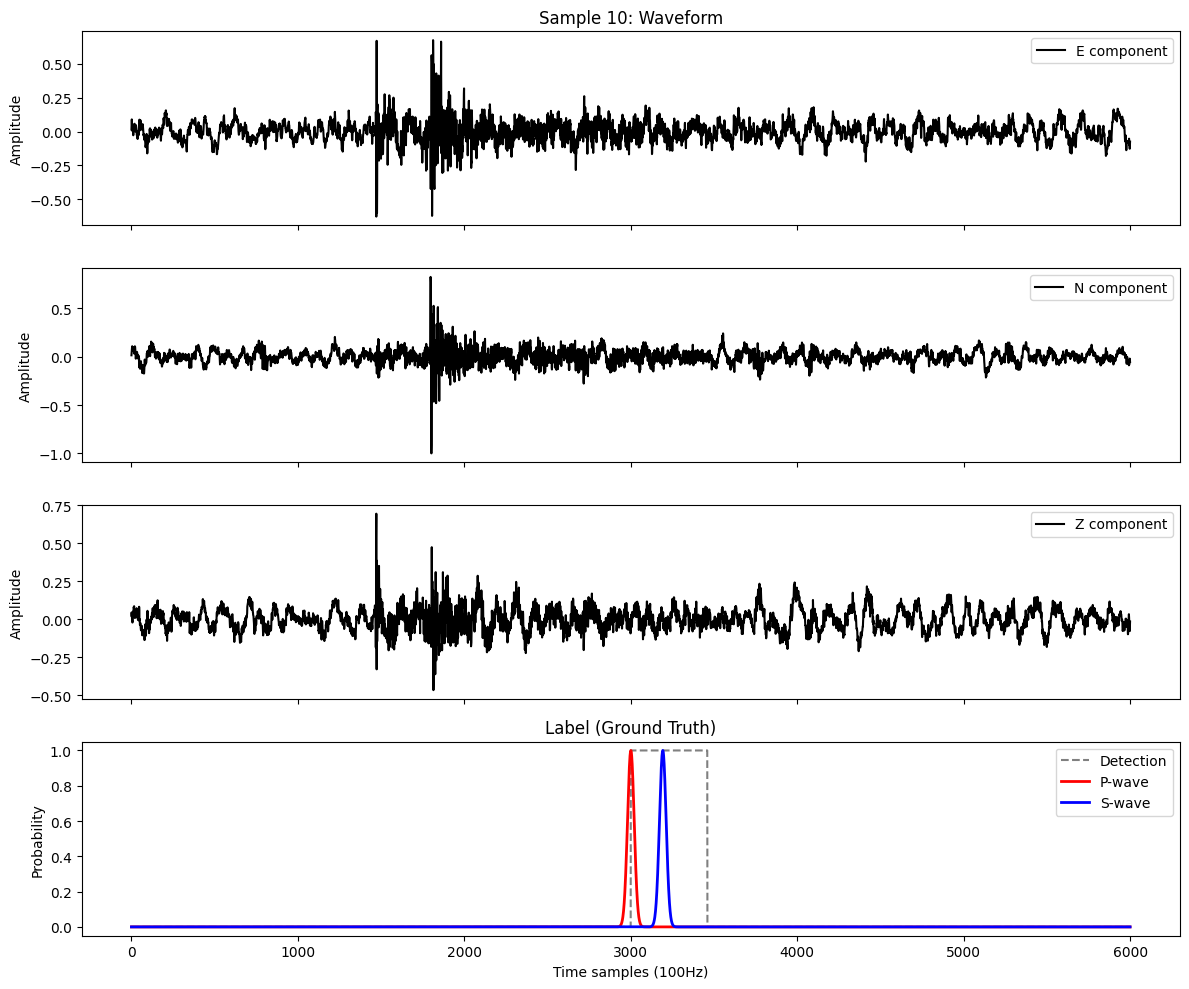

In [41]:
# 파일 경로
dataset_path = '/content/drive/MyDrive/TriAI/Data/포항_2017_전처리완료/EQT_Training_Dataset.h5'

with h5py.File(dataset_path, 'r') as f:
    # 데이터셋 크기 확인
    print(f"전체 샘플 수: {f['X'].shape[0]}")

    # 랜덤 선택
    sample_idx = 10

    X = f['X'][sample_idx]
    Y = f['Y'][sample_idx]

    # 시각화
    fig, ax = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

    # 1. 지진파 (E, N, Z 성분)
    ax[0].plot(X[:, 0], color='k', label='E component')
    ax[0].set_ylabel('Amplitude')
    ax[0].legend(loc='upper right')
    ax[0].set_title(f'Sample {sample_idx}: Waveform')

    ax[1].plot(X[:, 1], color='k', label='N component')
    ax[1].set_ylabel('Amplitude')
    ax[1].legend(loc='upper right')

    ax[2].plot(X[:, 2], color='k', label='Z component')
    ax[2].set_ylabel('Amplitude')
    ax[2].legend(loc='upper right')

    # 2. 정답 라벨 (Detection, P, S)
    ax[3].plot(Y[:, 0], label='Detection', color='gray', linestyle='--')
    ax[3].plot(Y[:, 1], label='P-wave', color='red', linewidth=2)
    ax[3].plot(Y[:, 2], label='S-wave', color='blue', linewidth=2)
    ax[3].set_ylabel('Probability')
    ax[3].set_xlabel('Time samples (100Hz)')
    ax[3].legend(loc='upper right')
    ax[3].set_title('Label (Ground Truth)')

    plt.tight_layout()
    plt.show()

## df 내보내기

In [42]:
# 지진 목록 데이터
gl_df.to_csv('/content/drive/MyDrive/TriAI/Data/포항_2017_전처리완료/gl_df.csv', index=False)
gl.to_csv('/content/drive/MyDrive/TriAI/Data/포항_2017_전처리완료/gl.csv', index=False)
# label
label.to_csv('/content/drive/MyDrive/TriAI/Data/포항_2017_전처리완료/label.csv', index=False)

In [43]:
gl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   발생시각           524 non-null    datetime64[ns]     
 1   규모             524 non-null    float64            
 2   깊이(km)         476 non-null    float64            
 3   위도             524 non-null    float64            
 4   경도             524 non-null    float64            
 5   발생일            524 non-null    datetime64[ns]     
 6   p_arrival_utc  476 non-null    datetime64[ns, UTC]
 7   s_arrival_utc  476 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), datetime64[ns](2), float64(4)
memory usage: 32.9 KB
